In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from scipy.stats import ttest_ind

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, precision_score,
                             recall_score, matthews_corrcoef, confusion_matrix,
                             roc_curve, auc, precision_recall_curve)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
DATA_DIR = "data"
OUT_DIR = "output/Phase_1"
os.makedirs(OUT_DIR, exist_ok=True)

In [4]:
SERIES_MATRIX = os.path.join(DATA_DIR, "GSE54564_series_matrix.txt")
BGX_FILE = os.path.join(DATA_DIR, "NCBI_Depression.bgx")

In [5]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
TOP_VARIANCE_KEEP = 3000
TOP_DE_GENES = 200
CORR_THRESHOLD = 0.7
N_JOBS = -1

In [6]:
pd.set_option("display.max_colwidth", 200)

In [7]:
def savefig(name):
    path = os.path.join(OUT_DIR, name)
    plt.savefig(path, bbox_inches="tight", dpi=150)
    print("Saved:", path)

In [8]:
print("\n[1] Loading series matrix (probe-level)...")
if not os.path.exists(SERIES_MATRIX):
    raise FileNotFoundError(f"Series matrix not found at {SERIES_MATRIX}")
raw = []
with open(SERIES_MATRIX, "r", encoding="utf-8", errors="ignore") as f:
    raw = f.readlines()
try:
    matrix_df = pd.read_csv(SERIES_MATRIX, sep="\t", header=0, index_col=0, low_memory=False)
except Exception:

    headers_line_idx = None
    for i, line in enumerate(raw):
        if line.strip().startswith("ID_REF") or line.strip().startswith("ID_REF\t"):
            headers_line_idx = i
            break
    if headers_line_idx is None:
        matrix_df = pd.read_csv(SERIES_MATRIX, sep="\t", comment="!", header=0, index_col=0, low_memory=False)
    else:

        matrix_df = pd.read_csv(SERIES_MATRIX, sep="\t", header=headers_line_idx, index_col=0, engine="python")
print("Probe-level dataframe sample(5):", matrix_df.sample(5))


[1] Loading series matrix (probe-level)...
Probe-level dataframe sample(5):                GSM1318948   GSM1318949   GSM1318950   GSM1318951   GSM1318952  \
ID_REF                                                                          
ILMN_2400030   133.002625   158.997818   125.008054   122.003501   130.009300   
ILMN_1682034   392.002547   344.997867   382.007868   439.003413   342.009093   
ILMN_1712360   114.002631   100.997803   110.008065    98.003508   104.009325   
ILMN_1775073   115.002630   118.997807   130.008050   112.003504   117.009312   
ILMN_1767662  2847.001804  3587.998721  3240.005794  2447.002853  3962.005564   

               GSM1318953   GSM1318954   GSM1318955   GSM1318956   GSM1318957  \
ID_REF                                                                          
ILMN_2400030   124.003768   133.017318   104.011667   152.992740   120.008170   
ILMN_1682034   265.003728   399.016950   316.011432   399.992934   354.007993   
ILMN_1712360    94.003776   102

In [9]:
print("\n[2] Loading BGX annotation (probe -> gene mapping)...")
if not os.path.exists(BGX_FILE):
    raise FileNotFoundError(f"BGX file not found at {BGX_FILE}")

with open(BGX_FILE, "r", encoding="utf-8", errors="ignore") as f:
    lines = f.readlines()
start = None
for i, line in enumerate(lines):
    if line.strip() == "[Probes]":
        start = i + 1
        break
if start is None:
    raise RuntimeError("Could not find [Probes] in BGX file")

bgx = pd.read_csv(BGX_FILE, sep="\t", skiprows=start, low_memory=False)
possible_probe_cols = [c for c in bgx.columns if c.lower() in ["probe_id", "probeid", "probe id", "id_ref", "ilMN_probe".lower()]]
if "Probe_Id" not in bgx.columns:
    for c in bgx.columns:
        if c.lower() in ["probe_id", "id_ref", "probeid", "probe id", "probe"]:
            bgx = bgx.rename(columns={c: "Probe_Id"})
            break
if "Symbol" not in bgx.columns:
    for c in bgx.columns:
        if "symbol" in c.lower() or "gene" in c.lower():
            # prefer a column that represents gene symbol
            if "symbol" in c.lower() or c.lower().startswith("ilmn_gene") or "gene symbol" in c.lower():
                bgx = bgx.rename(columns={c: "Symbol"})
                break
if "Probe_Id" not in bgx.columns or "Symbol" not in bgx.columns:
    found_probe = None
    found_sym = None
    for c in bgx.columns:
        if any(x in c.lower() for x in ["probe", "ilMN"]):
            found_probe = c
        if any(x in c.lower() for x in ["symbol", "gene", "ilmn_gene"]):
            found_sym = c
    if found_probe and found_sym:
        bgx = bgx.rename(columns={found_probe: "Probe_Id", found_sym: "Symbol"})
    else:
        raise RuntimeError("Could not find Probe_Id or Symbol columns in BGX")
bgx = bgx[["Probe_Id", "Symbol"]].dropna(subset=["Symbol"]).copy()
bgx["Probe_Id"] = bgx["Probe_Id"].astype(str).str.strip()
bgx["Symbol"] = bgx["Symbol"].astype(str).str.strip()
print("BGX loaded. Rows:", bgx.shape)
print("BGX loaded. Head(10):", bgx.head(10))


[2] Loading BGX annotation (probe -> gene mapping)...
BGX loaded. Rows: (36157, 2)
BGX loaded. Head(10):         Probe_Id     Symbol
0   ILMN_1725881   LOC23117
2   ILMN_1804174     FCGR2B
3   ILMN_1796063     TRIM44
4   ILMN_1811966  LOC653895
5   ILMN_1668162    DGAT2L3
6   ILMN_1715600  LOC387701
8   ILMN_1793729   C15orf39
10  ILMN_2296644    PCDHGA9
11  ILMN_1711283    PCDHGA9
12  ILMN_1682799   STAMBPL1


In [10]:
print("\n[3] Preparing expression matrix for merging (probe -> gene)")
if matrix_df.index.name is None or "id_ref" not in str(matrix_df.index.name).lower():
    if "ID_REF" in matrix_df.columns:
        matrix_df = matrix_df.rename(columns={"ID_REF":"Probe_Id"}).set_index("Probe_Id")
    else:
        possible = [c for c in matrix_df.columns if str(c).startswith("ILMN_")]
        if not possible:
            pass
expr = matrix_df.reset_index()
expr["Probe_Id"] = expr.iloc[:,0].astype(str).str.strip()


[3] Preparing expression matrix for merging (probe -> gene)


In [11]:
merged = expr.merge(bgx, on="Probe_Id", how="inner")
sample_cols = [c for c in merged.columns if str(c).startswith("GSM")]
if len(sample_cols) == 0:
    sample_cols = [c for c in merged.columns if c not in ("Probe_Id", "Symbol")]
print("Merged shape:", merged.shape, "| Sample cols detected:", len(sample_cols))

merged[sample_cols] = merged[sample_cols].apply(pd.to_numeric, errors="coerce")

Merged shape: (36157, 45) | Sample cols detected: 42


In [12]:
print("\n[4] Collapsing probes to genes (highest-variance probe per gene)")
merged["var"] = merged[sample_cols].var(axis=1)
collapsed = merged.sort_values("var", ascending=False).groupby("Symbol").head(1)
gene_expr = collapsed.set_index("Symbol")[sample_cols].copy()
print("Gene-level expression shape (genes x samples):", gene_expr.shape)


[4] Collapsing probes to genes (highest-variance probe per gene)
Gene-level expression shape (genes x samples): (25159, 42)


In [13]:
print("\n[5] Log2 transform (log2(x + 1))")
gene_expr_log = np.log2(gene_expr + 1)
print("Log2 done; sample values preview:", gene_expr_log.iloc[:3, :3].values.flatten()[:6])


[5] Log2 transform (log2(x + 1))
Log2 done; sample values preview: [13.3096184  14.54743706 14.31557368 14.55590693 13.82972289 15.13024807]


In [14]:
print("\n[6] Extracting labels from series matrix metadata")
labels_line = None
for line in raw:
    if "disease state" in line.lower():
        labels_line = line.strip()
        break
if labels_line is None:
    raise RuntimeError("Could not locate 'disease state' metadata line in series matrix")
parts = labels_line.split("\t")[1:]
labels_clean = [p.replace('"','').replace("disease state:", "").strip() for p in parts]
sample_ids = gene_expr_log.columns.tolist()
if len(labels_clean) != len(sample_ids):
    print("Warning: label count doesn't match sample count. Attempting alignment via header ordering.")
    header_line = None
    for line in raw:
        if line.lower().startswith("!sample_geo_accession"):
            header_line = line.strip()
            break
    if header_line is None:
        raise RuntimeError("Cannot align labels to samples; header line missing")
    header_samples = header_line.split("\t")[1:]
    if len(header_samples) == len(labels_clean):
        mapping = dict(zip(header_samples, labels_clean))
        labels_clean = [mapping.get(s, "") for s in sample_ids]
    else:
        raise RuntimeError("Could not align labels to sample columns automatically.")
y = pd.Series(labels_clean, index=sample_ids).map({"MDD case":1, "Control":0})
if y.isnull().any():
    y = pd.Series(labels_clean, index=sample_ids).str.lower().replace({
        'mdd case':1, 'mdd':1, 'case':1, 'control':0, 'healthy':0
    }).astype(int)
print("Label counts:", y.value_counts().to_dict())


[6] Extracting labels from series matrix metadata
Label counts: {1: 21, 0: 21}


In [15]:
print("\n[7] EDA: generating summary table, plots, PCA, heatmaps")
summary_table = [
    ["Probe-level rows", matrix_df.shape[0]],
    ["Gene-level rows", gene_expr_log.shape[0]],
    ["Number of samples", gene_expr_log.shape[1]],
    ["Class balance (1=MDD,0=Control)", y.value_counts().to_dict()]
]
print(tabulate(summary_table, headers=["Metric","Value"], tablefmt="github"))


[7] EDA: generating summary table, plots, PCA, heatmaps
| Metric                          | Value          |
|---------------------------------|----------------|
| Probe-level rows                | 48803          |
| Gene-level rows                 | 25159          |
| Number of samples               | 42             |
| Class balance (1=MDD,0=Control) | {1: 21, 0: 21} |


Saved: output/Phase_1\eda_density_raw_log2.png


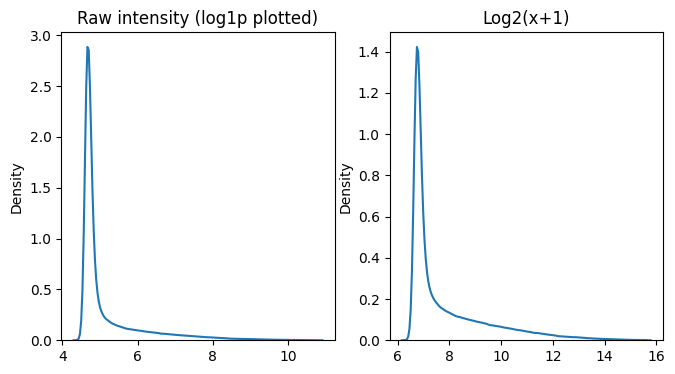

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.kdeplot(np.log1p(matrix_df[sample_cols].astype(float).values.flatten()), bw_adjust=0.5)
plt.title("Raw intensity (log1p plotted)")
plt.subplot(1,3,2)
sns.kdeplot(gene_expr_log.values.flatten(), bw_adjust=0.5)
plt.title("Log2(x+1)")
savefig("eda_density_raw_log2.png")
plt.show()

Saved: output/Phase_1\eda_pca_pc1_pc2.png


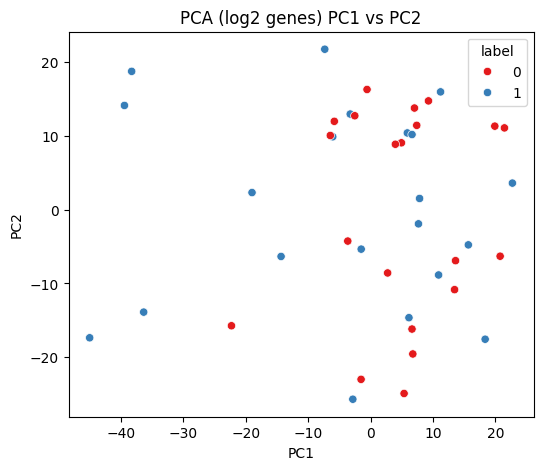

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state=RANDOM_STATE)
pca_scores = pca.fit_transform(gene_expr_log.T)  # samples x PCs
pca_df = pd.DataFrame(pca_scores, index=gene_expr_log.columns, columns=["PC1","PC2","PC3"])
pca_df["label"] = y.loc[pca_df.index].values
plt.figure(figsize=(6,5))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="label", palette="Set1")
plt.title("PCA (log2 genes) PC1 vs PC2")
savefig("eda_pca_pc1_pc2.png")
plt.show()

Saved: output/Phase_1\eda_heatmap_top50.png


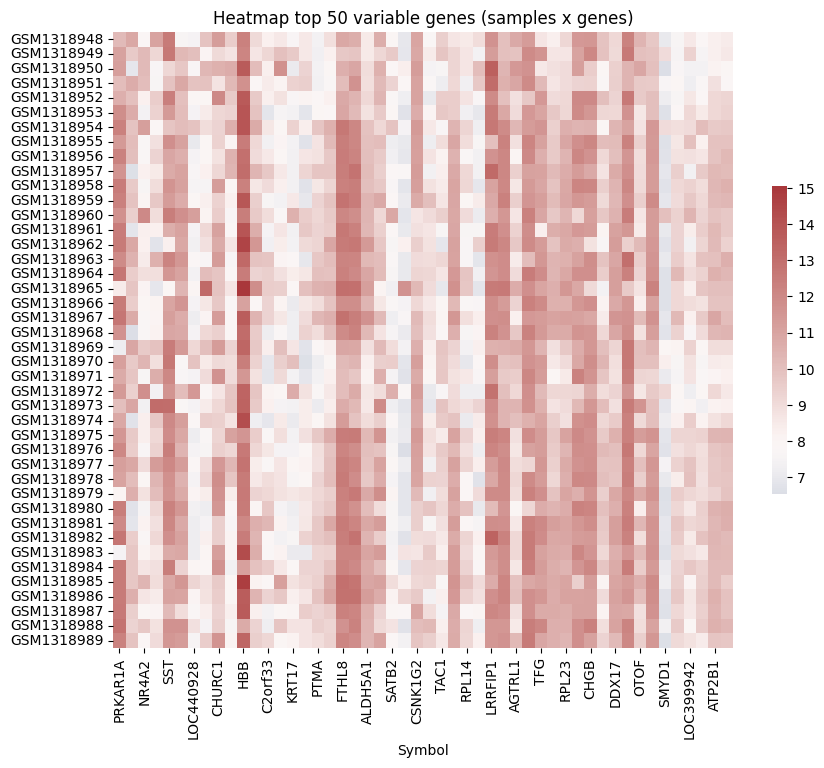

In [18]:
top50 = gene_expr_log.var(axis=1).sort_values(ascending=False).head(50).index
plt.figure(figsize=(10,8))
sns.heatmap(gene_expr_log.loc[top50].T, cmap="vlag", center=gene_expr_log.values.mean(), cbar_kws={'shrink':0.5})
plt.title("Heatmap top 50 variable genes (samples x genes)")
savefig("eda_heatmap_top50.png")
plt.show()

Saved: output/Phase_1\eda_corr_top50.png


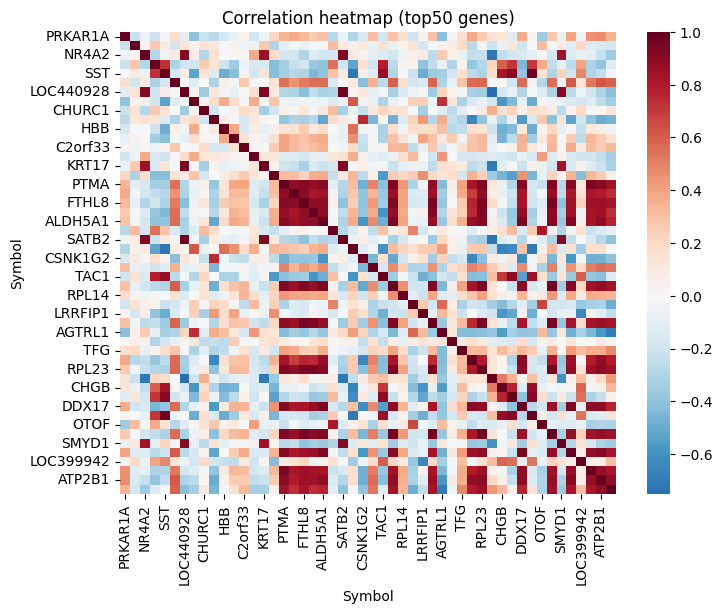

In [19]:
corr50 = gene_expr_log.loc[top50].T.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr50, cmap="RdBu_r", center=0)
plt.title("Correlation heatmap (top50 genes)")
savefig("eda_corr_top50.png")
plt.show()

In [20]:
print("\n[8] Train-test split (first) and normalization fit on training set only")
# create samples x genes matrix for scaling
X_full = gene_expr_log.T.copy()   # samples x genes
# split first
X_train_full, X_test_full, y_train, y_test = train_test_split(X_full, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)
print("Train/test shapes:", X_train_full.shape, X_test_full.shape)


[8] Train-test split (first) and normalization fit on training set only
Train/test shapes: (31, 25159) (11, 25159)


In [21]:
scaler = StandardScaler()
scaler.fit(X_train_full) 

,copy,True
,with_mean,True
,with_std,True


In [22]:
X_train_full_scaled = pd.DataFrame(scaler.transform(X_train_full), index=X_train_full.index, columns=X_train_full.columns)
X_test_full_scaled  = pd.DataFrame(scaler.transform(X_test_full), index=X_test_full.index, columns=X_test_full.columns)

Saved: output/Phase_1\eda_density_scaled_train.png


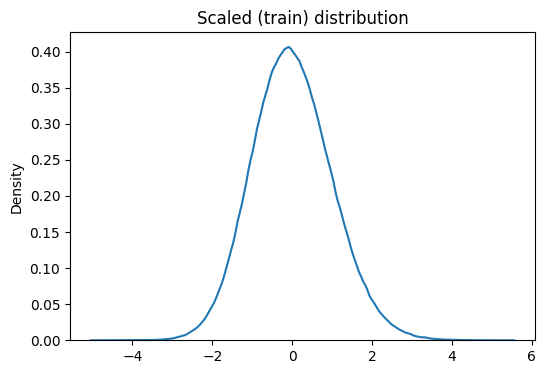

In [23]:
plt.figure(figsize=(6,4))
sns.kdeplot(X_train_full_scaled.values.flatten(), bw_adjust=0.6)
plt.title("Scaled (train) distribution")
savefig("eda_density_scaled_train.png")
plt.show()

In [24]:
print("\n[9] Feature selection on TRAIN only (variance filter -> DE t-test -> top200)")
# variance filter on training set
gene_var_train = X_train_full_scaled.var(axis=0).sort_values(ascending=False)
top_var_genes = gene_var_train.head(TOP_VARIANCE_KEEP).index.tolist()
print("Variance filter kept:", len(top_var_genes))


[9] Feature selection on TRAIN only (variance filter -> DE t-test -> top200)
Variance filter kept: 3000


In [25]:
train_raw = gene_expr_log.T.loc[X_train_full.index, top_var_genes]  # samples x genes (raw log2)
group1 = train_raw.loc[y_train == 1].values
group0 = train_raw.loc[y_train == 0].values
t_stats, pvals = ttest_ind(group1, group0, axis=0, equal_var=False, nan_policy='omit')
pvals = pd.Series(pvals, index=top_var_genes)
top_genes = pvals.nsmallest(TOP_DE_GENES).index.tolist()
print("Top DE genes selected:", len(top_genes))

Top DE genes selected: 200


In [26]:
X_train = X_train_full_scaled[top_genes].copy()
X_test  = X_test_full_scaled[top_genes].copy()
print("Model X_train shape:", X_train.shape, "X_test shape:", X_test.shape)

Model X_train shape: (31, 200) X_test shape: (11, 200)


In [27]:
models = {}

In [28]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
models["LogisticElasticNetCV"] = LogisticRegressionCV(
    Cs=5, cv=cv, penalty='elasticnet', solver='saga', scoring='roc_auc',
    l1_ratios=[0.2,0.5,0.8], max_iter=2000, class_weight="balanced", n_jobs=N_JOBS, random_state=RANDOM_STATE
)

In [29]:
# 2) Random Forest
models["RandomForest"] = RandomForestClassifier(n_estimators=500, 
                                                class_weight="balanced", 
                                                random_state=RANDOM_STATE, 
                                                n_jobs=N_JOBS
                                               )

In [30]:
# 3) LinearSVC (L1) wrapped in CalibratedClassifierCV for probabilities
svc_l1 = LinearSVC(C=0.01, 
                   penalty='l1', 
                   dual=False, 
                   max_iter=5000
                  )
models["LinearSVC_L1_Calibrated"] = CalibratedClassifierCV(svc_l1, 
                                                           cv=3
                                                          )

In [31]:
# 4) XGBoost
models["XGBoost"] = xgb.XGBClassifier(
    n_estimators=300, 
    use_label_encoder=False, 
    eval_metric='logloss', 
    random_state=RANDOM_STATE, 
    n_jobs=N_JOBS)

In [32]:
# 5) LightGBM
models["LightGBM"] = lgb.LGBMClassifier(
    n_estimators=300,
    num_leaves=7,
    min_data_in_leaf=1,
    min_data_in_bin=1,
    max_depth=3,
    learning_rate=0.05,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS
)

In [33]:
# 6) KNN
models["KNN"] = KNeighborsClassifier(
    n_neighbors=5
)

In [34]:
# 7) MLP
models["MLP"] = MLPClassifier(
    hidden_layer_sizes=(100,), 
    max_iter=1000, 
    random_state=RANDOM_STATE
)

In [35]:
results = []
fitted_models = {}

In [36]:
for name, model in models.items():
    print(f"\n-- Training {name} --")
    try:
        model.fit(X_train, y_train)
    except Exception as e:
        print(f"Model {name} failed to fit: {e}")
        continue
    fitted_models[name] = model

    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
    else:
        if hasattr(model, "decision_function"):
            df = model.decision_function(X_test)
            proba = (df - df.min()) / (df.max() - df.min() + 1e-9)
        else:
            proba = model.predict(X_test).astype(float)

    pred = (proba >= 0.5).astype(int)
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc = roc_auc_score(y_test, proba) if len(np.unique(y_test)) > 1 else np.nan
    mcc = matthews_corrcoef(y_test, pred)
    prec = precision_score(y_test, pred, zero_division=0)
    rec = recall_score(y_test, pred, zero_division=0)
    try:
        pr_prec, pr_rec, _ = precision_recall_curve(y_test, proba)
        pr_auc = auc(pr_rec, pr_prec)
    except Exception:
        pr_auc = np.nan

    results.append({
        "Model": name, "Accuracy": acc, "F1": f1, "ROC-AUC": roc,
        "PR-AUC": pr_auc, "MCC": mcc, "Precision": prec, "Recall": rec
    })

    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted"); plt.ylabel("True")
    savefig(f"cm_{name}.png")
    plt.close()

    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC={roc:.2f}")
    plt.plot([0,1],[0,1],"k--")
    plt.title(f"ROC: {name}"); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.legend(loc="lower right")
    savefig(f"roc_{name}.png")
    plt.close()

    try:
        if hasattr(model, "feature_importances_"):
            imp = pd.Series(model.feature_importances_, index=top_genes).sort_values(ascending=False)
            imp.head(20).to_csv(os.path.join(OUT_DIR, f"featimp_{name}.csv"), index=True)
            plt.figure(figsize=(6,6))
            imp.head(20).plot(kind="barh")
            plt.title(f"Top features - {name}")
            savefig(f"featimp_{name}.png")
            plt.close()
        elif hasattr(model, "coef_"):
            coefs = model.coef_
            if coefs.ndim > 1:
                coefs = coefs[0]
            imp = pd.Series(np.abs(coefs), index=top_genes).sort_values(ascending=False)
            imp.head(20).to_csv(os.path.join(OUT_DIR, f"coef_{name}.csv"))
            plt.figure(figsize=(6,6))
            imp.head(20).plot(kind="barh")
            plt.title(f"Top abs(coef) - {name}")
            savefig(f"featcoef_{name}.png")
            plt.close()
    except Exception as e:
        print("Could not extract feature importance for", name, e)



-- Training LogisticElasticNetCV --
Saved: output/Phase_1\cm_LogisticElasticNetCV.png
Saved: output/Phase_1\roc_LogisticElasticNetCV.png
Saved: output/Phase_1\featcoef_LogisticElasticNetCV.png

-- Training RandomForest --
Saved: output/Phase_1\cm_RandomForest.png
Saved: output/Phase_1\roc_RandomForest.png
Saved: output/Phase_1\featimp_RandomForest.png

-- Training LinearSVC_L1_Calibrated --
Saved: output/Phase_1\cm_LinearSVC_L1_Calibrated.png
Saved: output/Phase_1\roc_LinearSVC_L1_Calibrated.png

-- Training XGBoost --
Saved: output/Phase_1\cm_XGBoost.png
Saved: output/Phase_1\roc_XGBoost.png
Saved: output/Phase_1\featimp_XGBoost.png

-- Training LightGBM --
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Number of positive: 16, number of negative: 15
[LightGBM] [Info] Auto-choo

In [37]:
print("\n[11] Final metrics table (test set)")
metrics_df = pd.DataFrame(results).set_index("Model")
metrics_df = metrics_df[["Accuracy","F1","ROC-AUC","PR-AUC","MCC","Precision","Recall"]]
metrics_df.to_csv(os.path.join(OUT_DIR, "model_metrics_summary.csv"))
print(tabulate(metrics_df, headers="keys", tablefmt="github", floatfmt=".3f"))


[11] Final metrics table (test set)
| Model                   |   Accuracy |    F1 |   ROC-AUC |   PR-AUC |    MCC |   Precision |   Recall |
|-------------------------|------------|-------|-----------|----------|--------|-------------|----------|
| LogisticElasticNetCV    |      0.364 | 0.222 |     0.300 |    0.333 | -0.311 |       0.250 |    0.200 |
| RandomForest            |      0.364 | 0.222 |     0.300 |    0.338 | -0.311 |       0.250 |    0.200 |
| LinearSVC_L1_Calibrated |      0.455 | 0.625 |     0.500 |    0.727 |  0.000 |       0.455 |    1.000 |
| XGBoost                 |      0.364 | 0.364 |     0.400 |    0.362 | -0.267 |       0.333 |    0.400 |
| LightGBM                |      0.636 | 0.600 |     0.533 |    0.439 |  0.267 |       0.600 |    0.600 |
| KNN                     |      0.545 | 0.286 |     0.383 |    0.388 |  0.043 |       0.500 |    0.200 |
| MLP                     |      0.455 | 0.250 |     0.400 |    0.518 | -0.149 |       0.333 |    0.200 |


In [38]:
print("\nCross-validated ROC-AUC (5-fold) on entire dataset with selected top200 genes - results shown for context")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_results = []
for name, model in fitted_models.items():
    try:
        scores = cross_val_score(model, pd.concat([X_train, X_test]), pd.concat([y_train, y_test]), cv=cv, scoring="roc_auc", n_jobs=N_JOBS)
        cv_results.append((name, scores.mean(), scores.std()))
        print(f"{name}: mean AUC={scores.mean():.3f} (std={scores.std():.3f})")
    except Exception:
        print(f"{name}: CV failed")


Cross-validated ROC-AUC (5-fold) on entire dataset with selected top200 genes - results shown for context
LogisticElasticNetCV: mean AUC=0.893 (std=0.095)
RandomForest: mean AUC=0.820 (std=0.096)
LinearSVC_L1_Calibrated: mean AUC=0.500 (std=0.000)
XGBoost: mean AUC=0.690 (std=0.127)
LightGBM: mean AUC=0.720 (std=0.125)
KNN: mean AUC=0.821 (std=0.036)
MLP: mean AUC=0.860 (std=0.093)


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
Saved: output/Phase_1\roc_all_models.png


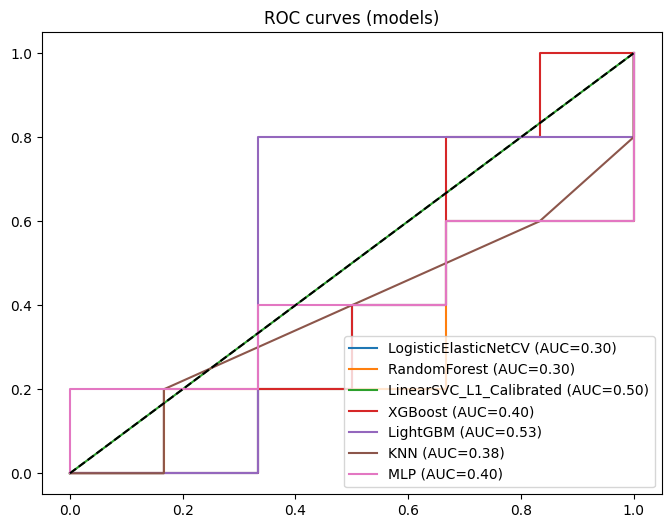

In [39]:
plt.figure(figsize=(8,6))
for name, model in fitted_models.items():
    try:
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(X_test)[:,1]
        elif hasattr(model, "decision_function"):
            df = model.decision_function(X_test)
            proba = (df - df.min())/(df.max()-df.min()+1e-9)
        else:
            proba = model.predict(X_test).astype(float)
        fpr, tpr, _ = roc_curve(y_test, proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, proba):.2f})")
    except Exception:
        continue
plt.plot([0,1],[0,1],"k--")
plt.legend(loc="lower right")
plt.title("ROC curves (models)")
savefig("roc_all_models.png")
plt.show()

In [40]:
print("\n[13] Selecting best model by ROC-AUC (test) and exporting top200 for Cytoscape")
metrics_df["ROC-AUC_filled"] = metrics_df["ROC-AUC"].fillna(-1)
best_name = metrics_df["ROC-AUC_filled"].idxmax()
best_model = fitted_models.get(best_name)
print("Best model:", best_name, "ROC-AUC:", metrics_df.loc[best_name, "ROC-AUC"])


[13] Selecting best model by ROC-AUC (test) and exporting top200 for Cytoscape
Best model: LightGBM ROC-AUC: 0.5333333333333334


In [41]:
if best_model is None:
    top_features_final = top_genes[:TOP_DE_GENES]
else:
    if hasattr(best_model, "feature_importances_"):
        imp = pd.Series(best_model.feature_importances_, index=top_genes).sort_values(ascending=False)
        top_features_final = imp.head(200).index.tolist()
    elif hasattr(best_model, "coef_"):
        coefs = best_model.coef_
        if coefs.ndim > 1:
            coefs = coefs[0]
        imp = pd.Series(np.abs(coefs), index=top_genes).sort_values(ascending=False)
        top_features_final = imp.head(200).index.tolist()
    else:
        top_features_final = top_genes[:TOP_DE_GENES]

In [42]:
mean_mdd = gene_expr_log.loc[top_features_final].T.loc[y==1].mean()
mean_ctrl = gene_expr_log.loc[top_features_final].T.loc[y==0].mean()
mean_diff = (mean_mdd - mean_ctrl).reindex(top_features_final)

In [43]:
if 'imp' in locals() and isinstance(imp, pd.Series):
    importance_series = imp.reindex(top_features_final).fillna(0)
else:
    importance_series = pd.Series(np.linspace(1, 0.1, len(top_features_final)), index=top_features_final)

nodes_out = pd.DataFrame({
    "Gene": top_features_final,
    "MeanDifference": mean_diff.values,
    "Importance": importance_series.values
})
nodes_out.to_csv(os.path.join(OUT_DIR, "cytoscape_nodes.csv"), index=False)
print("Saved cytoscape_nodes.csv")

Saved cytoscape_nodes.csv


In [44]:
corr_top = gene_expr_log.loc[top_features_final].T.corr()
edges = []
for i, g1 in enumerate(corr_top.columns):
    for j, g2 in enumerate(corr_top.columns):
        if j <= i: continue
        r = corr_top.loc[g1, g2]
        if abs(r) >= CORR_THRESHOLD:
            edges.append({"Source": g1, "Target": g2, "Correlation": r})
edges_df = pd.DataFrame(edges)
edges_df.to_csv(os.path.join(OUT_DIR, "cytoscape_edges.csv"), index=False)
print("Saved cytoscape_edges.csv. Edges kept:", edges_df.shape[0])

Saved cytoscape_edges.csv. Edges kept: 650


In [45]:
print("\n[14] Saving final artifacts list")
for f in os.listdir(OUT_DIR):
    print("-", f)

print("\nPipeline completed. All outputs are in the 'output/' folder.")
print("Inspect: model_metrics_summary.csv, cytoscape_nodes.csv, cytoscape_edges.csv, plots (png).")


[14] Saving final artifacts list
- cm_KNN.png
- cm_LightGBM.png
- cm_LinearSVC_L1_Calibrated.png
- cm_LogisticElasticNetCV.png
- cm_MLP.png
- cm_RandomForest.png
- cm_XGBoost.png
- coef_LogisticElasticNetCV.csv
- cytoscape_edges.csv
- cytoscape_nodes.csv
- eda_corr_top50.png
- eda_density_raw_log2.png
- eda_density_scaled_train.png
- eda_heatmap_top50.png
- eda_pca_pc1_pc2.png
- featcoef_LogisticElasticNetCV.png
- featimp_LightGBM.csv
- featimp_LightGBM.png
- featimp_RandomForest.csv
- featimp_RandomForest.png
- featimp_XGBoost.csv
- featimp_XGBoost.png
- model_metrics_summary.csv
- roc_all_models.png
- roc_KNN.png
- roc_LightGBM.png
- roc_LinearSVC_L1_Calibrated.png
- roc_LogisticElasticNetCV.png
- roc_MLP.png
- roc_RandomForest.png
- roc_XGBoost.png

Pipeline completed. All outputs are in the 'output/' folder.
Inspect: model_metrics_summary.csv, cytoscape_nodes.csv, cytoscape_edges.csv, plots (png).
